# making figure_2 


This notebook contains code for producing the full global tree, generated by running genomes from countries with >5 genomes though Beast 1.8 with a skygrid population size prior, and inferring migration history with asymmetric DTA with BSSVA for all regions. This script was adapted from [Louise Moncla's Mumps phylo work](https://github.com/blab/mumps-wa-phylodynamics)and from [Gytis Dudas'ebola work](https://github.com/ebov/space-time)

In [19]:
import baltic as bt
import pandas as pd
import arviz as az

from datetime import datetime as dt
from datetime import timedelta
import time
from io import StringIO
import altair as alt
from zipfile import ZipFile
import math
import re


import sys, subprocess, glob, os, shutil, re, importlib
from subprocess import call
import imp
from scipy.stats import gaussian_kde
import geopandas

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
from matplotlib import rc
import textwrap as textwrap
from textwrap import wrap

import numpy as np
from scipy.special import binom

from altair import datum
import arviz as az
from scipy.stats import gaussian_kde

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': 22})

In [3]:
def convertDate(x,start,end):
    """ Converts calendar dates between given formats """
    return dt.strftime(dt.strptime(x,start),end)

In [4]:
def parse_tree(tree, traitType):
    # add together probabilities for divisions in the same regions

    # parse leaf and node information into a dictionary for plotting
    metadata = {}
    node_types = {}
    node_probs = {}

    for k in tree.Objects: ## iterate over objects in tree
        if k.branchType=='leaf':
            division = k.traits[traitType]
            #region = regions[division]
            metadata[k] = {}
            metadata[k]["division"] = division
            #metadata[k]["region"] = region
            node_probs[k] = k.traits[traitType + ".prob"]  # for a leaf, this is always 1.0

        # parse the nodes now and pick out the type trait
        if k.branchType=='node':
            node_division = k.traits[traitType]
            division_prob = k.traits[traitType + ".prob"]

            #node_region = regions[node_division]       
            geo_set = k.traits[traitType + '.set']
            geo_set_prob = k.traits[traitType + '.set.prob']

            node_prob = 0
            for i in range(len(geo_set)):
                division = geo_set[i]
                geo_prob = geo_set_prob[i]

                #if region == node_region:
                node_prob += geo_prob


            node_types[k] = {}
            node_types[k]["division"] = node_division
            node_probs[k] = division_prob

    return(node_probs, node_types)

In [5]:
def enumerate_subtrees(tree, locTrait):
    
    traitName=locTrait

    tree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    tree_strings={division:[] for division in division_order}
    subtype_trees={division:[] for division in division_order}

    for k in sorted(tree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k

        ## get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName]      # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:       # if parent has a trait block, use that trait, else assign to ancestor
            kploc=kp.traits[traitName]              # kploc = trait of parental node
        else:
            kploc='ancestor'

        kc=kloc     
        ## if states do not match
        if kloc!=kploc:      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName]==kloc     # traverse tree for all nodes whose traitname = kc
            #print('subtree resulting from %s>%s switch, traversing within %s'%(kploc,kloc,kloc))
            subtree=tree.subtree(k,traverse_condition=traverse_condition) #traitName = traitName ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state

            if subtree != None:
                subtree.traverse_tree()
                subtree.sortBranches()
                tree_strings[kloc].append(subtree.toString()) ## remember subtree string, subtree object itself
                subtype_trees[kloc].append((kploc,subtree))
    
    return(subtype_trees)

In [6]:

colors = {"CentralEurope":"#D0A854",
          "NorthAmerica":"#2664A5",
          "SouthAmerica":"#A76BB1",
          "SouthernEurope":"#D07954",
          "WesternEurope":"#356D4C",
          "ancestor": "#B9B9B9"
         }
uncertainty_color = "#B9B9B9"
division_order = [ 'NorthAmerica', "WesternEurope", 'CentralEurope', "SouthernEurope", 'SouthAmerica' ]
new_order = [ 'NorthAmerica','SouthAmerica' ,"SouthernEurope", "WesternEurope" ]

In [8]:
tree_path = "../dta/results/main/1000_prev_sub_region_dta_mcc.tree"
# load trees
tree = bt.loadNexus(tree_path, tip_regex='_([0-9\-]+)$')
tree.setAbsoluteTime(2023.0068)

In [9]:
# parse leaf and node information into a dictionary for plotting
metadata = {}
node_types = {}
node_probs = {}
pos_support = []

for k in tree.Objects: ## iterate over objects in tree
    if k.branchType=='leaf':
        division = k.traits['region']
        metadata[k] = {}
        metadata[k]["division"] = division
        node_probs[k] = k.traits["region.prob"]
    
    # parse the nodes now and pick out the type trait
    if k.branchType=='node':
        node_division = k.traits["region"]
        node_types[k] = {}
        node_types[k]["division"] = node_division
        node_probs[k] = k.traits["region.prob"]
        pos_support.append(k.traits["posterior"])

[2022.19478458 2022.23561621]
[2022.2315664  2022.23561621]
2022.2166758355443


/Users/mparedes/opt/miniconda3/envs/nextstrain/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


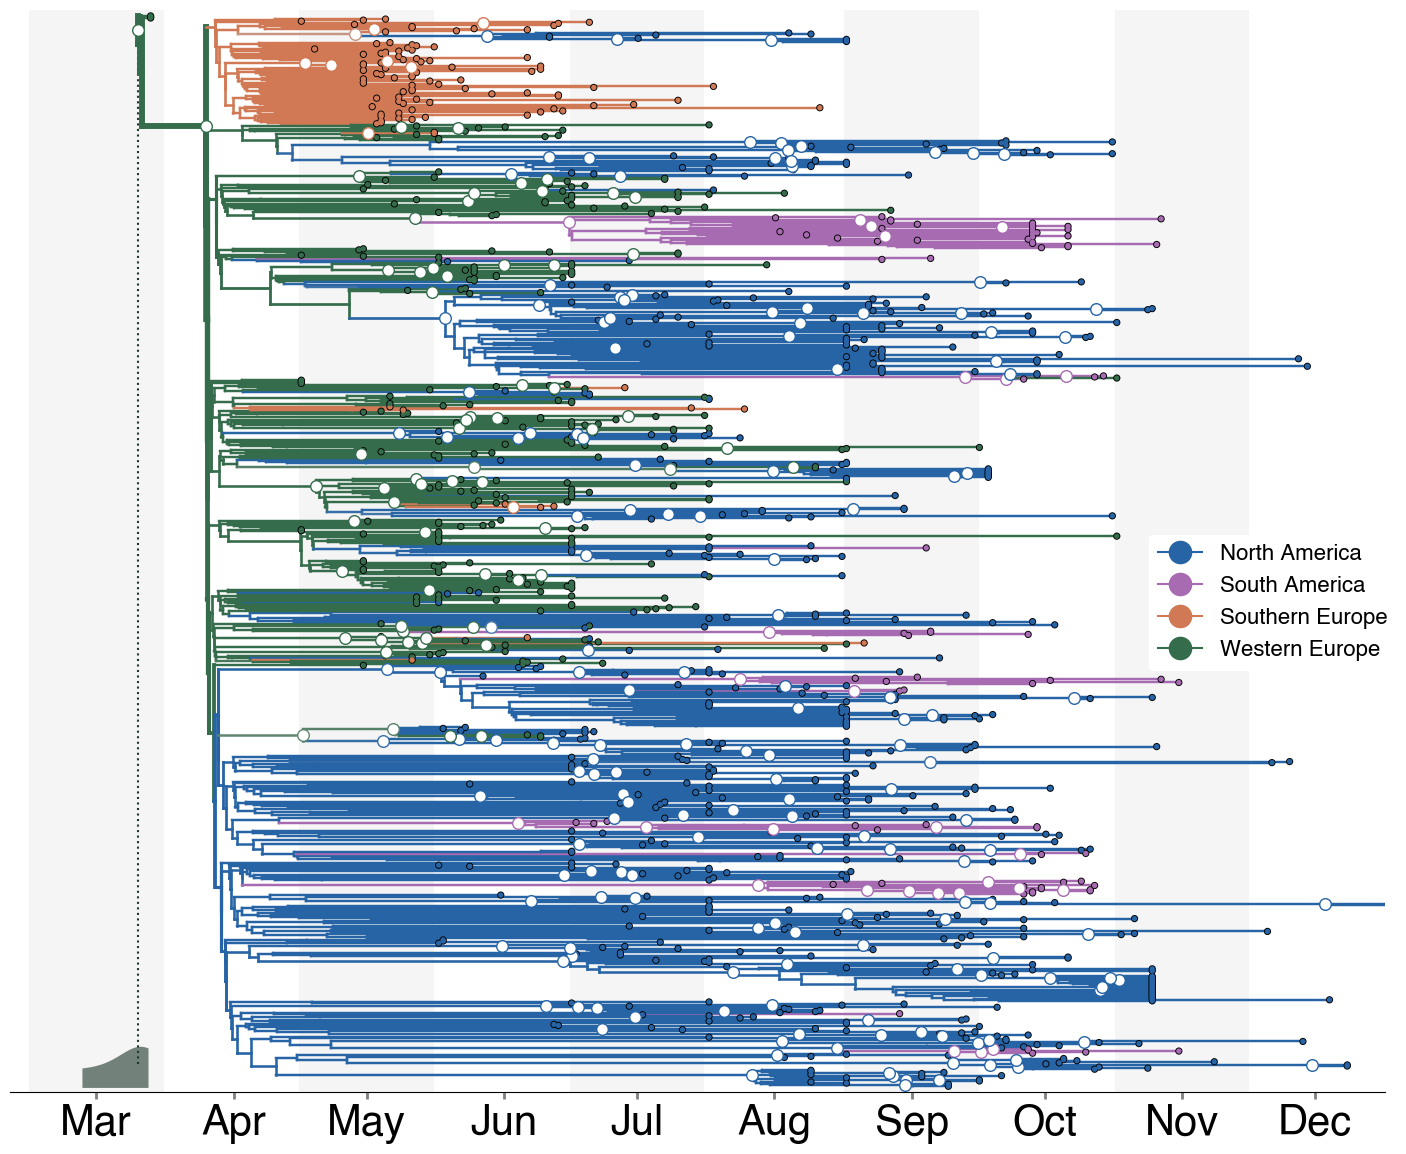

In [11]:
root_path = "../dta/results/main/fixed_region_pre_sub_1000_masked.log"
burnin=10000000
with open(root_path) as f:
    f = f.readlines()
for line in f:
    if not line.startswith("#"):
       
        l=line.strip('\n').split('\t')
        if l[0]=='state':
            header=l
            param_idx={x:i for i,x in enumerate(header)}
            params=header[1:]
            rootHeights={x:[] for x in params}
        elif float(l[0])>=burnin:
            for param in params:
                rootHeights[param].append(float(l[param_idx[param]]))


print(az.hdi(np.array(rootHeights['age(root)']), 0.95))
print(az.hdi(np.array(rootHeights['age(root)']), 0.5))
print(np.mean(np.array(rootHeights['age(root)'])))


fig,ax = plt.subplots(figsize=(16,12),facecolor='w')



branchWidth=1.75 ## default branch width
tipSize = 15

# k objects are tips, nodes, branches
for k in tree.Objects: ## iterate over objects in tree
    x=k.absoluteTime ## or use absolute time instead
    y=k.y 
    
    xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        base_color=colors[metadata[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color,base_color], N=256)
        c = color_ramp(node_probs[k])
        s=tipSize
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        number_children = len(k.leaves)
        node_branchwidth = branchWidth + number_children*0.0025
        base_color=colors[node_types[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color, base_color], N=256)
        c = color_ramp(node_probs[k])
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]
        if k.traits['posterior']>=0.5:
            ax.scatter(x,y,s=70,facecolor='w',edgecolor=c,zorder=100)
    ax.plot([xp,x],[y,y],lw=node_branchwidth,color=c,ls='-',zorder=9)
    
for intro in rootHeights.keys():
    if intro=='age(root)':

        hpdLo,hpdHi=az.hdi(np.array(rootHeights['age(root)']), 0.95)

        x_grid=np.linspace(hpdLo,hpdHi,100)
        kde=gaussian_kde(rootHeights['age(root)'])
        y_grid=kde.evaluate(x_grid)+20

        root_y=[(y*0.8)-1 for y in y_grid]


        c='#1C3828'


        topX,topY=tree.Objects[0].absoluteTime,tree.Objects[0].children[0].y

        bottomX=topX
        bottomY=(kde.evaluate(bottomX)*0.8)-1

        ax.plot([bottomX,topX],[bottomY,topY],ls=':',color=c)

        ax.fill_between(x_grid,root_y,y2=-1,facecolor= "#1C3828",edgecolor='none',alpha=0.6)
        #ax.plot(x_grid,root_y,lw=2,color=c,ls='-')
        
    # add in a legend
    han_list = []

    # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
for key in new_order:
    marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = re.findall('[A-Z][^A-Z]*', key)[0] + " " + re.findall('[A-Z][^A-Z]*', key)[1], markersize = 16)
    han_list.append(marker)

 

xDates=['%04d-%02d-01'%(y,m) for y in range(2021,2024) for m in range(1,13)]

every=1
[ax.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.tick_params(axis='x',labelsize=16,size=0)    
    
# set axis limits, remove border lines         
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.set_ylim(-5,tree.ySpan+5)
ax.set_xlim(2022.15,2023)
ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='x',labelsize=30,size=5, width=2,color='grey')
   # set date labels every 4
ax.set_yticklabels([])

# in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
# bbox arguments are: x, y, with 0 being furthest left and bottom
ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[0.82, 0.38], loc=3,prop={'size': 16}, facecolor='w')

fig.tight_layout()
plt.gcf().subplots_adjust(right=0.88)
plt.savefig('../figures/mcc_dta_skygrid.png',dpi=300,bbox_inches='tight')

plt.show()

## functions to read in trees files and extract migration jumps

In [20]:
def get_taxa_lines(tree_path):    

    lines_to_write = ""
    with open(trees, 'rU') as infile:
        for line in infile: ## iterate through each line
            if 'state' not in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                lines_to_write = lines_to_write + line

    return(lines_to_write)

In [21]:
def get_burnin_value(tree_path, burnin_percent):
    with open(tree_path, 'rU') as infile:
        numtrees = 0
        for line in infile: ## iterate through each line
            if 'state' in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                numtrees += 1
    
    burnin = numtrees * burnin_percent
    return(burnin)

In [22]:
#making decimal date from string dates adapted from stackoverflow (thank you coding geniuses)
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [43]:
def enumerate_migration_events(tree, traitType):
        
    output_dict = {}
    migration_events_counter = 0
        
    for k in tree.Objects:
        trait = k.traits[traitType]
        parent_node = k.parent
        
        if traitType not in parent_node.traits:
            parent_trait = "root"
        
        # only write out migration events that are not from root to deme
        else:
            parent_trait = parent_node.traits[traitType]
        
        if (trait != parent_trait) and (parent_trait != "root"):
            migration_events_counter += 1

            migration_event = parent_trait + "-to-" + trait
            #migration_date = parent_node.absoluteTime                

            # write to output dictionary
            output_dict[migration_events_counter] = {"type":migration_event, #"date":migration_date,
                                                    "parent_host":parent_trait,
                                                    "child_host": trait, "tree_length": sum([x.length for x in tree.Objects])}

    return(output_dict)

In [44]:
#counts all migration events and records parent and child nodes
def run_mig_counts(all_trees, traitType):
    start_time = time.time()
    with open(all_trees, "r") as infile:

        tree_counter = 0
        trees_processed = 0
        migrations_dict = {}

        for line in infile:
            if 'tree STATE_' in line:
                tree_counter += 1

                if tree_counter > burnin:
                    temp_tree = StringIO(taxa_lines + line)
                    tree = bt.loadNexus(temp_tree, tip_regex='_([0-9\-]+)$')
                    tree.setAbsoluteTime(2023.0068)
                    trees_processed += 1

                    # iterate through the tree and pull out all migration events
                    migrations_dict[tree_counter] = enumerate_migration_events(tree, traitType)

    # print the amount of time this took
    total_time_seconds = time.time() - start_time
    total_time_minutes = total_time_seconds/60
    print("this took", total_time_seconds, "seconds (", total_time_minutes," minutes) to run on", trees_processed, "trees")
   
    """this will generate a multi-index dataframe from the migrations dictionary"""
    migrations_df = pd.DataFrame.from_dict({(i,j): migrations_dict[i][j] 
                           for i in migrations_dict.keys() 
                           for j in migrations_dict[i].keys()},
                       orient='index')

    migrations_df.reset_index(inplace=True)
    migrations_df.rename(columns={'level_0': 'tree_number', 'level_1': 'migration_event_number'}, inplace=True)
    
    return(migrations_df)

## persistence times

In [45]:
#need to convert the decimal dates back to calendar dates 
def convert_persistence(number):
    d = timedelta(days=(number)*(365))
    return d.total_seconds()

In [46]:
#this is adapted from Bedford et al in nature where we start at a time and then walk backwards up the tree until the location changes
def estimate_persistence(tree, typeTrait):
        
    output_dict = {}
    persistence_counter = 0
        
    for k in tree.Objects:
        
        
        trait = k.traits[typeTrait]
        parent_node = k.parent
        if ('root' in parent_node.traits) or (parent_node.traits == {}) :
            parent_trait = "root"
        
        # only write out migration events that are not from root to deme
        elif k.branchType=='leaf':
            tip_date= k.absoluteTime
            tip_name = k.name
            confirm = True
            while confirm == True:
                try:
                    parent_trait = parent_node.traits[typeTrait]
                    
                    if trait != parent_trait:
                        persistence_counter += 1

                        migration_event = parent_trait + "-to-" + trait
                        migration_date = parent_node.absoluteTime
                        
                        persistence =  tip_date - migration_date

                        # write to output dictionary
                        output_dict[persistence_counter] = {"type":migration_event, "migration date":migration_date,"tip date": tip_date, "persistance": persistence, "tip_name" : tip_name,
                                                        "parent_host":parent_trait,
                                                        "child_host": trait}
                        confirm = False
                    else:    
                        parent_node = parent_node.parent    
                except:
                    break
        else:
            continue
    
    return(output_dict)

In [47]:
trees =  "../dta/results/main/ds_skygrid_1000.trees"

In [48]:
all_trees = trees
burnin_percent = 0.2
taxa_lines = get_taxa_lines(all_trees)
burnin = get_burnin_value(all_trees, burnin_percent)
print(burnin)

412.8


In [49]:
migrations_df = run_mig_counts(all_trees, traitType = "region")


this took 270.7419776916504 seconds ( 4.51236629486084  minutes) to run on 1652 trees


In [50]:
imports = migrations_df.groupby(["child_host", "tree_number"])['migration_event_number'].count().reset_index()
exports = migrations_df.groupby(["parent_host", "tree_number"])['migration_event_number'].count().reset_index()

imports.index = imports.child_host
exports.index = exports.parent_host

#mig_dict = {}
mig_dict_imports={x:[] for x in imports["child_host"].unique()}
mig_dict_exports={x:[] for x in exports["parent_host"].unique()}

for items in imports.index.unique():
    mig_dict_imports[items].append(imports.loc[items,"migration_event_number"].values)
    mig_dict_exports[items].append(exports.loc[items,"migration_event_number"].values)

In [51]:
print(np.quantile(persist_dict["NorthAmerica"], 0.25))


107.99135924209202


In [52]:
colors = {"CentralEurope":"#D0A854",
          "NorthAmerica":"#2664A5",
          "SouthAmerica":"#A76BB1",
          "SouthernEurope":"#D07954",
          "WesternEurope":"#356D4C",
          "ancestor": "#B9B9B9"
         }


In [53]:
start_time = time.time()

with open(trees, "r") as infile:
    
    tree_counter = 0
    trees_processed = 0
    persistence_dict = {}
    
    for line in infile:
       # print(line)
        if 'tree STATE_' in line:
            tree_counter += 1
            

            if tree_counter > burnin:
                temp_tree = StringIO(taxa_lines + line)
                tree = bt.loadNexus(temp_tree, tip_regex='_([0-9\-]+)$')
                tree.setAbsoluteTime(2023.0068)
                trees_processed += 1

            # iterate through the tree and pull out all migration events
                persistence_dict[tree_counter] =  estimate_persistence(tree, "region")
            
# print the amount of time this took
total_time_seconds = time.time() - start_time
total_time_minutes = total_time_seconds/60
print("this took", total_time_seconds, "seconds (", total_time_minutes," minutes) to run on", trees_processed, "trees")
persistence_df = pd.DataFrame.from_dict({(i,j): persistence_dict[i][j] 
                           for i in persistence_dict.keys() 
                           for j in persistence_dict[i].keys()},
                       orient='index')


this took 250.58836674690247 seconds ( 4.176472779115041  minutes) to run on 1652 trees


In [54]:
persistence_df
persistence_df.reset_index(inplace=True)
persistence_df.rename(columns={'level_0': 'tree_number', 'level_1': 'migration_event_number'}, inplace=True)

persist = persistence_df.groupby(["child_host", "tree_number"])['persistance'].mean().reset_index()
persist['persistance'] = persist['persistance'].map(convert_persistence)
persist['persistance'] = persist['persistance'].div(86400) #calculating number of days from seconds
persist.index = persist.child_host

persist_dict={x:[] for x in persist["child_host"].unique()}

for items in persist.index.unique():
    persist_dict[items].append(persist.loc[items,"persistance"].values)

NorthAmerica 8.0
NorthAmerica 10.0
NorthAmerica 12.0
SouthAmerica 1.0
SouthAmerica 1.0
SouthAmerica 2.0
SouthernEurope 1.0
SouthernEurope 2.0
SouthernEurope 3.0
WesternEurope 41.0
WesternEurope 46.0
WesternEurope 53.0
NorthAmerica 107.99135924209202
NorthAmerica 110.87805605975116
NorthAmerica 113.85584138568576
SouthAmerica 96.48917770768229
SouthAmerica 100.66068370034142
SouthAmerica 104.72475413391493
SouthernEurope 39.318154819444445
SouthernEurope 42.67153512784722
SouthernEurope 47.49851373879051
WesternEurope 21.944215912442132
WesternEurope 24.538189681087964
WesternEurope 28.875051811765044


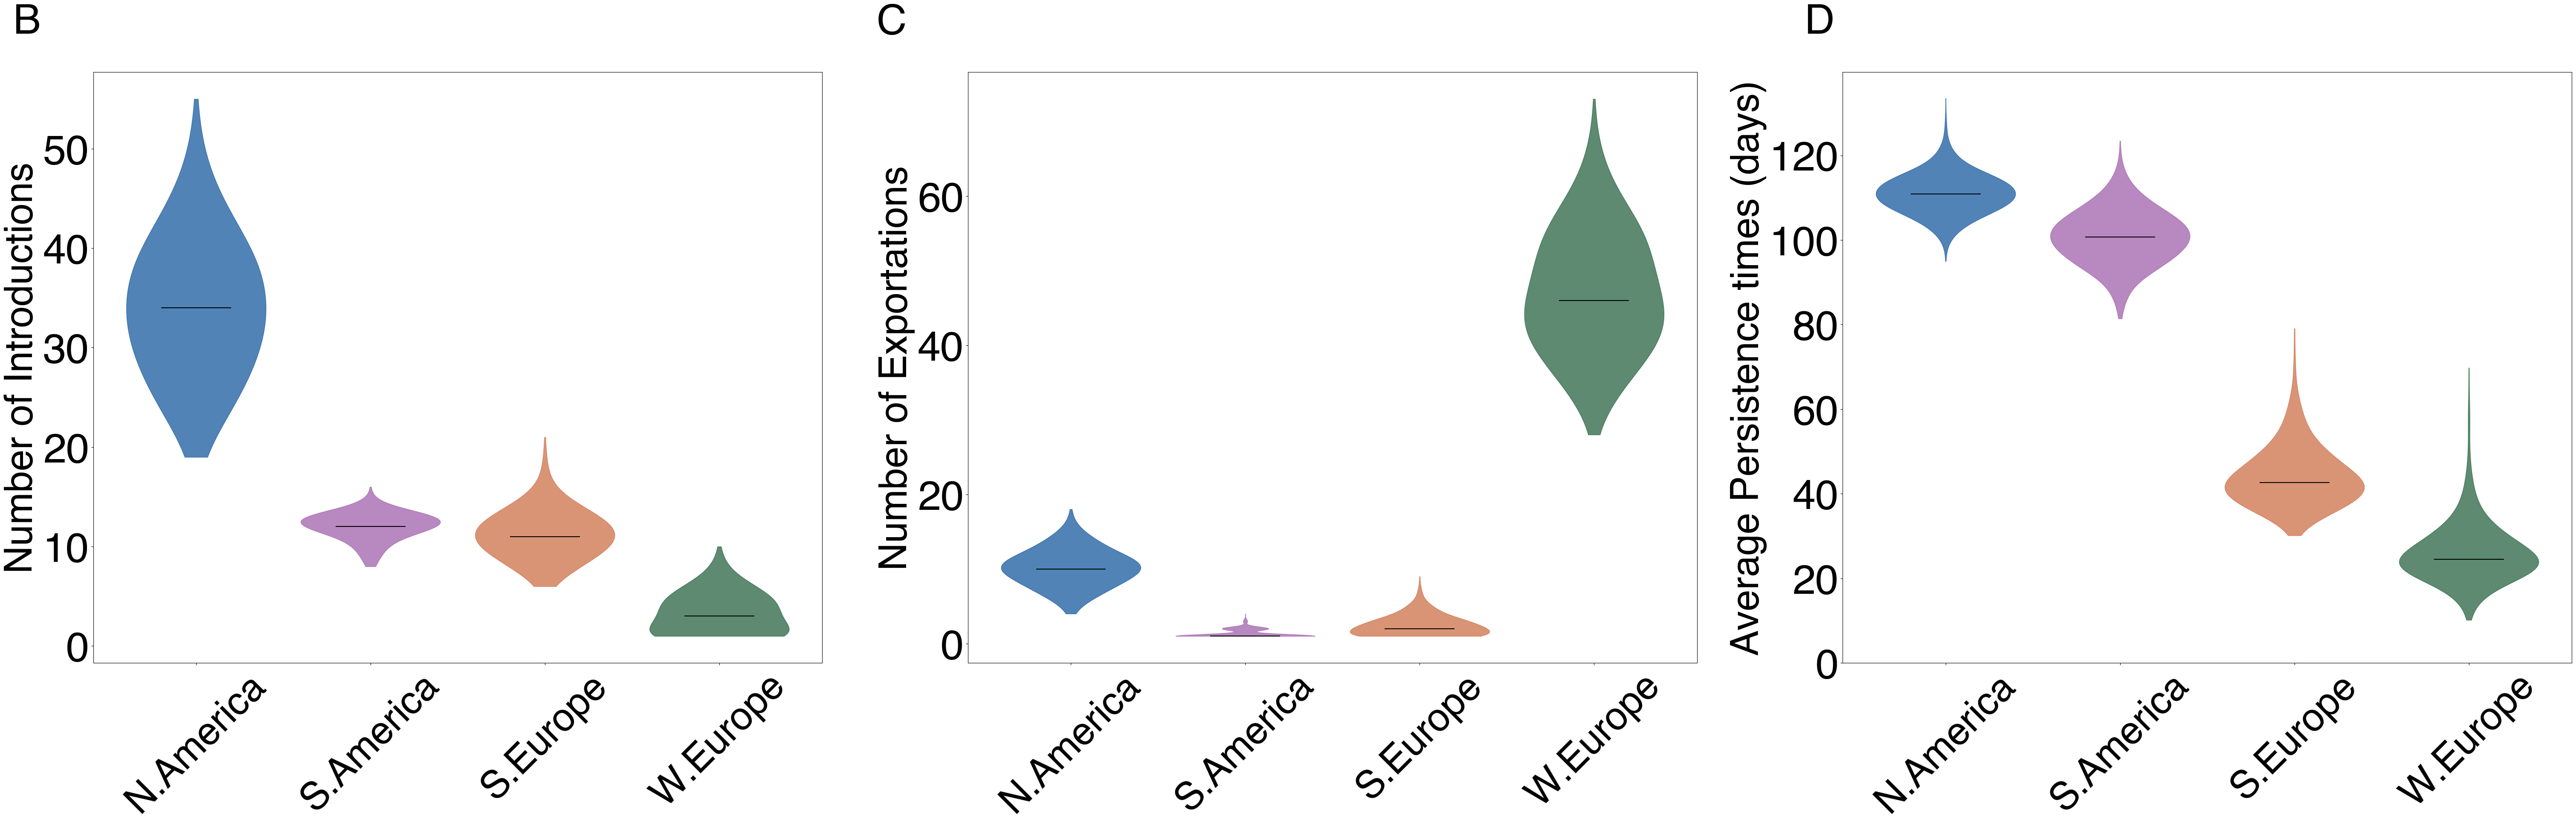

In [55]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(75, 18), facecolor='w')
#fig.suptitle('Publication Style Lettering', fontsize=30, fontweight='bold', x=0.05, y=1.05)
region_list = ["N.America", "S.America", "S.Europe", "W.Europe"]

# First plot
pos = []
for index, place in enumerate(mig_dict_imports.keys()):


    violin_plot = axs[0].violinplot(mig_dict_imports[place], positions=[index], widths=0.8,
                                    showmedians=True, bw_method=0.6, showextrema=False)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmedians"].set_edgecolor("black")
    pos.append(index)

divisions = list(mig_dict_imports.keys())
axs[0].set_xticks(pos)
axs[0].set_xticklabels(region_list,  fontsize=65,rotation=45, fontweight='bold')
axs[0].set_ylabel("Number of Introductions", fontsize=65, fontweight='bold')
axs[0].tick_params(axis='y', labelsize=70)

# Second plot
pos = []
for index, place in enumerate(mig_dict_exports.keys()):
    print(place, np.quantile(mig_dict_exports[place], 0.25))
    print( place, np.quantile(mig_dict_exports[place], 0.5))
    print(place, np.quantile(mig_dict_exports[place], 0.75))
    violin_plot = axs[1].violinplot(mig_dict_exports[place], positions=[index], widths=0.8,
                                    showmedians=True, bw_method=0.5, showextrema=False)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmedians"].set_edgecolor("black")
    pos.append(index)

divisions = list(mig_dict_exports.keys())
axs[1].set_xticks(pos)
axs[1].set_xticklabels(region_list,  fontsize=65,rotation=45, fontweight='bold')
axs[1].set_ylabel("Number of Exportations", fontsize=65, fontweight='bold')
axs[1].tick_params(axis='y', labelsize=70)

# Third plot
pos = []
for index, place in enumerate(persist_dict.keys()):
    print(place, np.quantile(persist_dict[place], 0.25))
    print(place, np.quantile(persist_dict[place], 0.5))
    print(place, np.quantile(persist_dict[place], 0.75))
    violin_plot = axs[2].violinplot(persist_dict[place], positions=[index], widths=0.8,
                                    showmedians=True, bw_method=0.5, showextrema=False)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmedians"].set_edgecolor("black")
    pos.append(index)

countries = list(persist_dict.keys())
axs[2].set_xticks(pos)
axs[2].set_xticklabels(region_list, fontsize=65,rotation=45, fontweight='bold')
axs[2].set_ylabel("Average Persistence times (days)", fontsize=65, fontweight='bold')
axs[2].tick_params(axis='y', labelsize=70)
axs[2].set_ylim(bottom=0)


# Add publication style lettering in the upper left corner
fig.text(0.1, 0.93, "B", fontsize=70, fontweight='bold')
fig.text(0.37, 0.93, "C", fontsize=70, fontweight='bold')
fig.text(0.66, 0.93, "D", fontsize=70, fontweight='bold')

plt.savefig('../figures/1000_dta_region_combined.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
## calculating migration rate as number of migration events divided by total tree length

In [ ]:
mig_rate_df = migrations_df.tree_number.value_counts().reset_index().rename(columns = {"index":"tree", "tree_number": "mig_count"}) 
mig_rate_df["tree_length"] = 0; mig_rate_df

In [ ]:
migrations_df.index = migrations_df.tree_number
mig_rate_df.tree_length = migrations_df.iloc[mig_rate_df.tree, 5].values[1] ; mig_rate_df


In [ ]:
for index, row in mig_rate_df.iterrows():
    mig_rate_df.iloc[index, 2] = migrations_df.iloc[int(row.tree),5]

In [ ]:
mig_rate_df["weighted_count"] = mig_rate_df.mig_count/mig_rate_df.tree_length


In [ ]:
mig_rate_df.weighted_count.mean()

az.hdi(mig_rate_df.weighted_count.astype(float).to_numpy(), 0.95)

## sensitivity analysis - alternative subsampling schemes

In [30]:
tree_path = "../dta/results/sensitivity/regiona_noCE_mcc.tree"
# load trees
tree = bt.loadNexus(tree_path, tip_regex='_([0-9\-]+)$')
tree.setAbsoluteTime(2023.0068)

In [31]:
tree.treeStats()


Tree height: 0.781776
Tree length: 156.635337
strictly bifurcating tree
annotations present

Numbers of objects in tree: 2037 (1018 nodes and 1019 leaves)



In [22]:
# parse leaf and node information into a dictionary for plotting
metadata = {}
node_types = {}
node_probs = {}
pos_support = []

for k in tree.Objects: ## iterate over objects in tree
    if k.branchType=='leaf':
        division = k.traits['region']
        metadata[k] = {}
        metadata[k]["division"] = division
        node_probs[k] = k.traits["region.prob"]
    
    # parse the nodes now and pick out the type trait
    if k.branchType=='node':
        node_division = k.traits["region"]
        node_types[k] = {}
        node_types[k]["division"] = node_division
        node_probs[k] = k.traits["region.prob"]
        pos_support.append(k.traits["posterior"])

[2022.19328169 2022.23561339]
[2022.22881049 2022.23561096]
2022.2233761597324


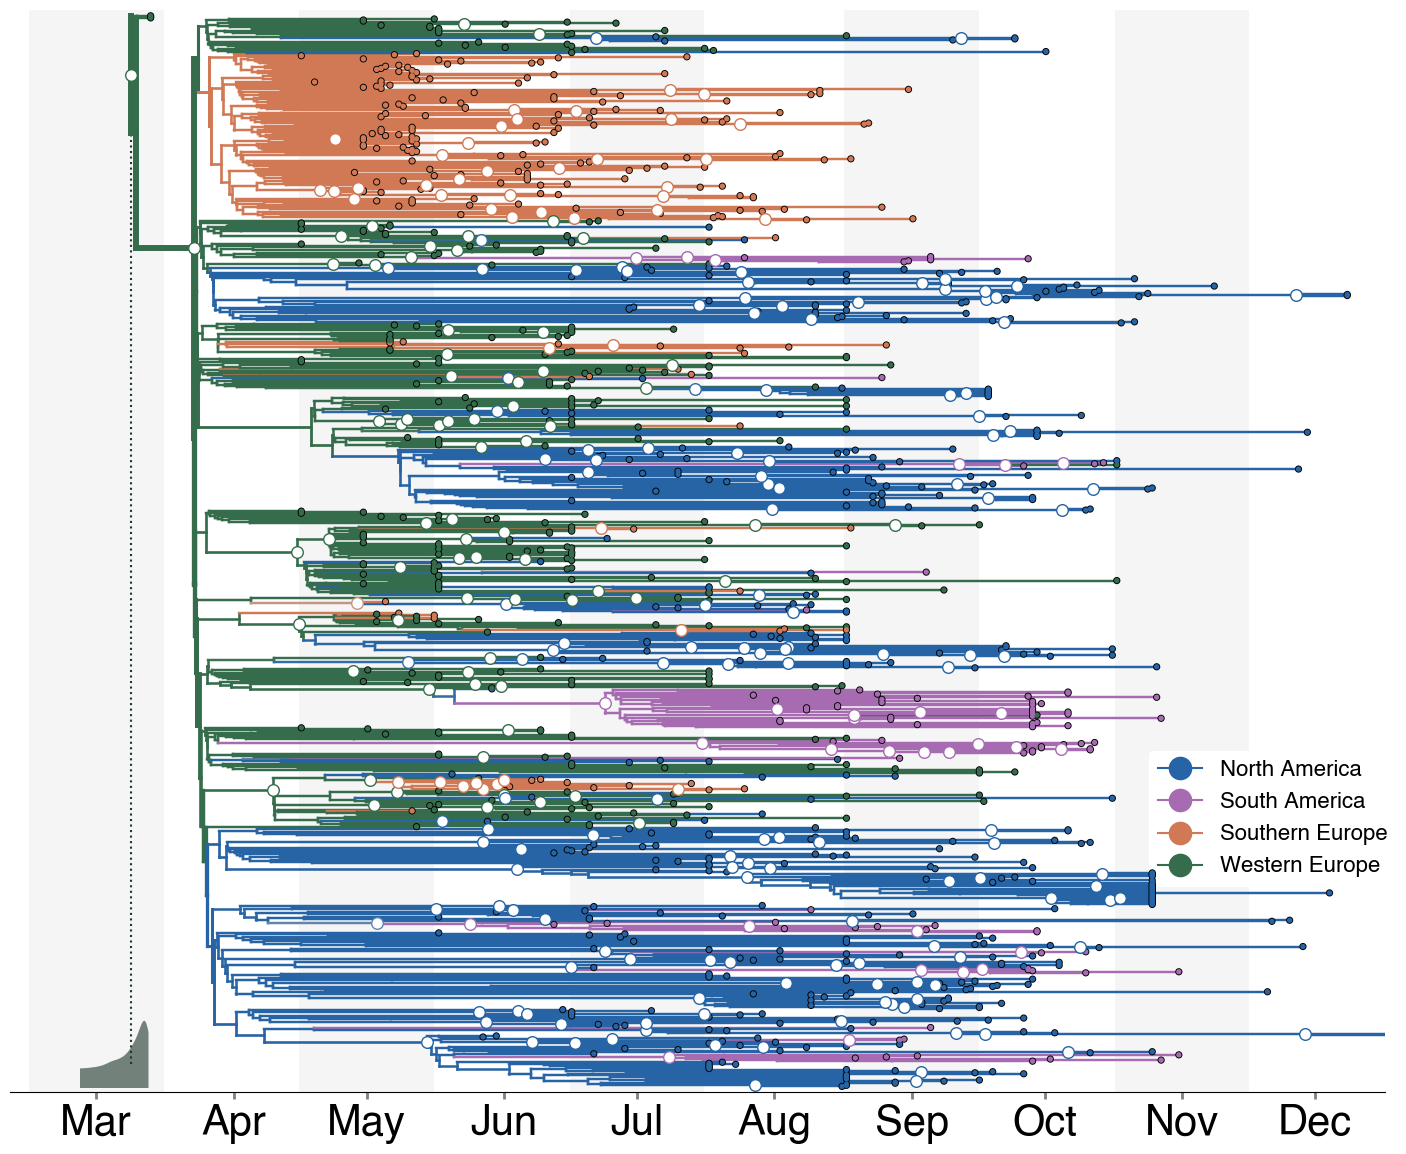

In [25]:
root_path = "../dta/results/sensitivity/regional_noCE.log"
burnin=10000000
with open(root_path) as f:
    f = f.readlines()
for line in f:
    if not line.startswith("#"):
       
        l=line.strip('\n').split('\t')
        if l[0]=='state':
            header=l
            param_idx={x:i for i,x in enumerate(header)}
            params=header[1:]
            rootHeights={x:[] for x in params}
        elif float(l[0])>=burnin:
            for param in params:
                rootHeights[param].append(float(l[param_idx[param]]))


print(az.hdi(np.array(rootHeights['age(root)']), 0.95))
print(az.hdi(np.array(rootHeights['age(root)']), 0.5))
print(np.mean(np.array(rootHeights['age(root)'])))



fig,ax = plt.subplots(figsize=(16,12),facecolor='w')



branchWidth=1.75 ## default branch width
tipSize = 15

# k objects are tips, nodes, branches
for k in tree.Objects: ## iterate over objects in tree
    x=k.absoluteTime ## or use absolute time instead
    y=k.y 
    
    xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        base_color=colors[metadata[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color,base_color], N=256)
        c = color_ramp(node_probs[k])
        s=tipSize
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        number_children = len(k.leaves)
        node_branchwidth = branchWidth + number_children*0.0025
        base_color=colors[node_types[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color, base_color], N=256)
        c = color_ramp(node_probs[k])
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]
        if k.traits['posterior']>=0.5:
            ax.scatter(x,y,s=70,facecolor='w',edgecolor=c,zorder=100)
    ax.plot([xp,x],[y,y],lw=node_branchwidth,color=c,ls='-',zorder=9)
    
for intro in rootHeights.keys():
    if intro=='age(root)':

        hpdLo,hpdHi=az.hdi(np.array(rootHeights['age(root)']), 0.95)

        x_grid=np.linspace(hpdLo,hpdHi,100)
        kde=gaussian_kde(rootHeights['age(root)'])
        y_grid=kde.evaluate(x_grid)+20

        root_y=[(y*0.8)-1 for y in y_grid]


        c='#1C3828'
            #intro='reservoir'



        topX,topY=tree.Objects[0].absoluteTime,tree.Objects[0].children[0].y

        bottomX=topX
        bottomY=(kde.evaluate(bottomX)*0.8)-1

        ax.plot([bottomX,topX],[bottomY,topY],ls=':',color=c)

        ax.fill_between(x_grid,root_y,y2=-1,facecolor= "#1C3828",edgecolor='none',alpha=0.6)
        #ax.plot(x_grid,root_y,lw=2,color=c,ls='-')
        
    # add in a legend
    han_list = []

    # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
for key in new_order:
    marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = re.findall('[A-Z][^A-Z]*', key)[0] + " " + re.findall('[A-Z][^A-Z]*', key)[1], markersize = 16)
    han_list.append(marker)

# ax3 = fig.add_axes([0.68, 0.75, 0.16, 0.2])
# ax3.hist(pos_support, alpha = 0.7)
# #ax.hist(pos_support, 50, density=True, facecolor='g', alpha=0.75)    
# ax3.spines['left'].set_visible(False)
# #ax.spines['right'].set_visible(False)
# ax3.spines['top'].set_visible(False) 
# ax3.set_xlabel("Posterior Node Support", size=10)
# ax3.set_ylabel("Count", size=10)
# ax3.tick_params(axis='x',labelsize=10,size=0)    
# ax3.tick_params(axis='y',labelsize=10,size=0)    

xDates=['%04d-%02d-01'%(y,m) for y in range(2021,2024) for m in range(1,13)]

every=1
[ax.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.tick_params(axis='x',labelsize=16,size=0)    
    
# set axis limits, remove border lines         
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.set_ylim(-5,tree.ySpan+5)
ax.set_xlim(2022.15,2023)
ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='x',labelsize=30,size=5, width=2,color='grey')
   # set date labels every 4
ax.set_yticklabels([])

# in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
# bbox arguments are: x, y, with 0 being furthest left and bottom
ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[0.82, 0.18], loc=3,prop={'size': 16}, facecolor='w')

fig.tight_layout()
plt.gcf().subplots_adjust(right=0.88)
plt.savefig('../figures/mcc_dta_regional_subsampling_mcc.png',dpi=300,bbox_inches='tight')

plt.show()

## making map of countries and regions represented

In [25]:
colors = {"Canada":"#133253",
          "United States of America":"#2664A5",
        
          
          # greens
          "United Kingdom":"#1C3828",
          "Germany":"#356D4C",
          "Switzerland":"#81A48F",
          "Austria":"#B3C8BC",
          "France":"#CCDAD2",

          "Belgium":"#438B62",
          #"Netherlands":"#60B684",

          
          # yellows
          "Slovakia":"#D0A854",
          "Slovenia":"#EEC060",

          
          # oranges
          "Italy":"#D07954",
          "Portugal":"#EEA160",
          "Spain":"#F4C49C",
          
          # purples
          "Colombia":"#2D1E45",
          "Peru":"#695B82",
          "ancestor":'grey'

          
          # reds

          #"Finland":"#C5656E"
         }

uncertainty_color = "#B9B9B9"

division_order = ["Canada",
"United States of America",
"United Kingdom",
"Germany",
"Switzerland",
"Austria",
"France",
"Belgium",
#"Netherlands",
"Slovakia",
"Slovenia",
"Italy",
"Portugal",
"Spain",
"Colombia",
"Peru"
#"Finland"
                
] 

In [26]:
division_order


['Canada',
 'United States of America',
 'United Kingdom',
 'Germany',
 'Switzerland',
 'Austria',
 'France',
 'Belgium',
 'Slovakia',
 'Slovenia',
 'Italy',
 'Portugal',
 'Spain',
 'Colombia',
 'Peru']

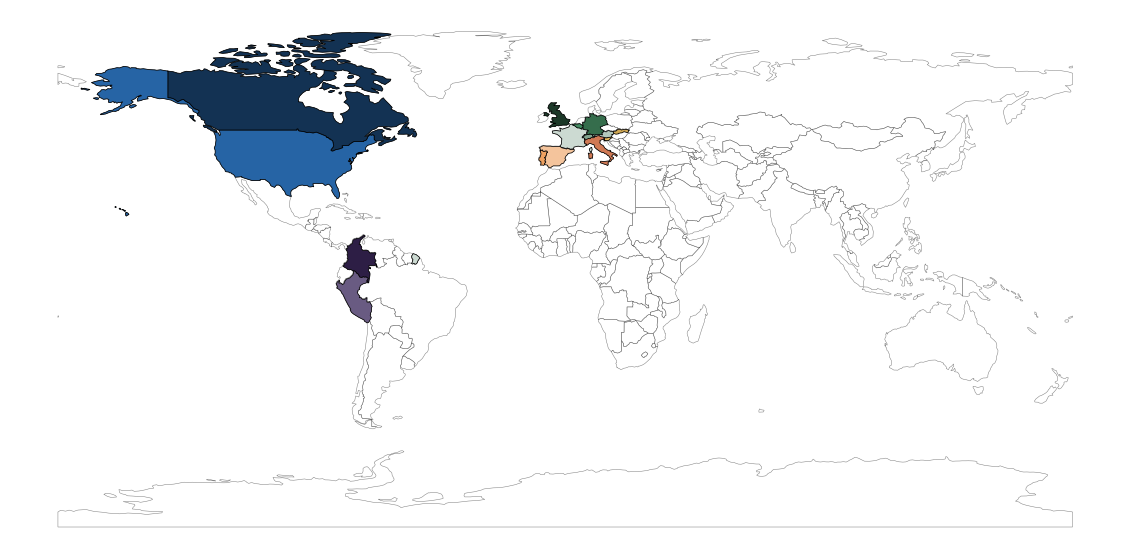

In [27]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(alpha=0.5, color="white", edgecolor="black", linewidth=0.5, figsize=(20,18))

for country in division_order: 
    world[world.name == country].plot(color=colors[country],
                                      ax=ax, edgecolor="black",
                                      linewidth=0.75)
    
ax.set_axis_off()
plt.savefig('map_wide.png')
plt.show() 

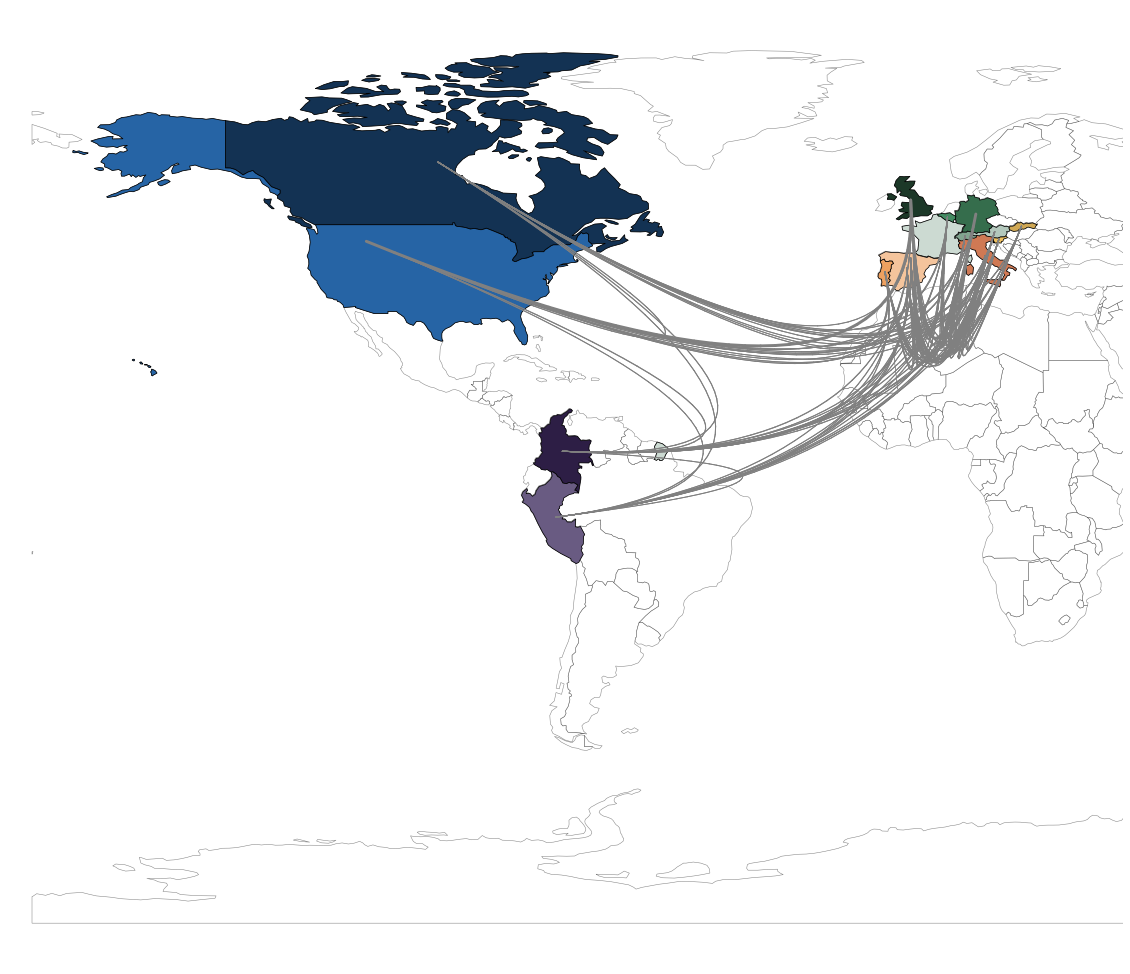

In [27]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(alpha=0.5, color="white", edgecolor="black", linewidth=0.5, figsize=(20,18))

for country in division_order: 
    world[world.name == country].plot(color=colors[country],
                                      ax=ax, edgecolor="black",
                                      linewidth=0.75)

root_path = "/Users/mparedes/Desktop/mpox_rhino/300_dta_country_masked_skygrid.log"
burnin=10000000
with open(root_path) as f:
    f = f.readlines()
for line in f:
    if not line.startswith("#"):
       
        l=line.strip('\n').split('\t')
        if l[0]=='state':
            header=l
            param_idx={x:i for i,x in enumerate(header)}
            params=header[1:]
            rootHeights={x:[] for x in params}
        elif float(l[0])>=burnin:
            for param in params:
                rootHeights[param].append(float(l[param_idx[param]]))


for headers in rootHeights.keys():
    if "country.rates" in headers:
        direction_mean = 0
        origin = headers.split(".")[2] 
        destination = headers.split(".")[3] 
        if origin == "UnitedKingdom":
            origin = "United Kingdom"
        if origin == "USA":
            origin = "United States of America"
        if destination == "UnitedKingdom":
            destination = "United Kingdom"
        if destination == "USA":
            destination = "United States of America"
        oriX,oriY=country_centroids[["lat", "long"]][country_centroids["name"] == origin].to_numpy()[0]
        desX,desY=country_centroids[["lat", "long"]][country_centroids["name"] == destination].to_numpy()[0]
        direction_mean = np.mean(rootHeights[headers])

        #destinationXs.append(desX)
        #destinationYs.append(desY)


        #print normalized_height,normalized_parent_height
        ## define Bezier curve
        distance=math.sqrt(math.pow(oriX-desX,2)+math.pow(oriY-desY,2))


        ## get Bezier line coordinates
        curve=Bezier([(oriX,oriY),0.3,(desX,desY)],0.0,1.0,num=40)

        #midpoint=np.mean([normalized_parent_height,normalized_height])

        ## iterate through Bezier curve coordinates, alter colour according to height
        for i in range(len(curve)-1):
            x1,y1=curve[i]
            x2,y2=curve[i+1]
            frac=(i/float(len(curve)))

            ax.plot([x1,x2],[y1,y2],lw= direction_mean,color="gray",
                     solid_capstyle='round')
            #ax.plot([x1,x2],[y1,y2],lw=6+4*frac,color='k', solid_capstyle='round')
ax.set_axis_off()
ax.set_xlim(-185, 40)

plt.savefig('map_wide.png')
plt.show() 

In [34]:
region_centroids = pd.read_csv("region_lat_log.csv")
country_centroids = pd.read_csv("countries_lat_long.csv")

In [35]:
region_centroids

,Unnamed: 0,region_coarse,lat,long
0,0,CentralEurope,17.222905,47.426067
1,1,NorthAmerica,-105.370909,53.587352
2,2,SouthAmerica,-73.734769,-2.632175
3,3,SouthernEurope,0.156001,40.911296
4,4,WesternEurope,5.222324,48.761221


In [1011]:
foo1, foo2 = country_centroids[["lat", "long"]][country_centroids["name"] == "Canada"].to_numpy()[0]

In [36]:
def Bezier(points,start,end,num=10):
    """Build Bezier curve from points.
    """
    N = len(points)
    t = np.linspace(start, end, num)
    curve = np.zeros((num, 2))
    for ii in range(N):
        curve += np.outer(Bernstein(N - 1, ii)(t), points[ii])
        
    return curve

In [37]:
def Bernstein(n, k):
    """Bernstein polynomial.
    """
    coeff = binom(n, k)

    def _bpoly(x):
        return coeff * x ** k * (1 - x) ** (n - k)

    return _bpoly

In [33]:
root_path = "/Users/mparedes/Desktop/mpox_rhino/300_dta_region_unmasked.log"
burnin=10000000
with open(root_path) as f:
    f = f.readlines()
for line in f:
    if not line.startswith("#"):
       
        l=line.strip('\n').split('\t')
        if l[0]=='state':
            header=l
            param_idx={x:i for i,x in enumerate(header)}
            params=header[1:]
            rootHeights={x:[] for x in params}
        elif float(l[0])>=burnin:
            for param in params:
                rootHeights[param].append(float(l[param_idx[param]]))

 


In [34]:
for headers in rootHeights.keys():
    #if "country.rates" in headers:
    print(headers)
    #origin = headers.split(".")[2] 
    #destination = headers.split(".")[3] 

joint
prior
likelihood
treeModel.rootHeight
age(root)
treeLength
skyline.popSize1
skyline.popSize2
skyline.popSize3
skyline.popSize4
skyline.popSize5
skyline.popSize6
skyline.popSize7
skyline.popSize8
skyline.popSize9
skyline.popSize10
skyline.groupSize1
skyline.groupSize2
skyline.groupSize3
skyline.groupSize4
skyline.groupSize5
skyline.groupSize6
skyline.groupSize7
skyline.groupSize8
skyline.groupSize9
skyline.groupSize10
gtr.rates.rateAC
gtr.rates.rateAG
gtr.rates.rateAT
gtr.rates.rateCG
gtr.rates.rateCT
gtr.rates.rateGT
frequencies1
frequencies2
frequencies3
frequencies4
alpha
pInv
default.clock.rate
region.clock.rate
default.meanRate
region.meanRate
region.rates.CentralEurope.NorthAmerica
region.rates.CentralEurope.SouthAmerica
region.rates.CentralEurope.SouthernEurope
region.rates.CentralEurope.WesternEurope
region.rates.NorthAmerica.SouthAmerica
region.rates.NorthAmerica.SouthernEurope
region.rates.NorthAmerica.WesternEurope
region.rates.SouthAmerica.SouthernEurope
region.rates.S

In [16]:
division_order = ["Canada",
"United States of America",
"United Kingdom",
"Germany",
"Switzerland",
"Austria",
"France",
"Belgium",
#"Netherlands",
"Slovakia",
"Slovenia",
"Italy",
"Portugal",
"Spain",
"Colombia",
"Peru"
#"Finland"
                
] 



#region = {('Canada','USA'):'North America',
#          'Finland':'Northern Europe',
#          ('Austria','Germany','Switzerland','UnitedKingdom','France','Belgium','Netherlands'):'Western Europe', 
#          ('Slovakia','Slovenia'):'Central/Eastern Europe',
#          ('Italy','Portugal','Spain'):'Southern Europe',
#          ('Colombia','Peru'):'South America'}




         # blues
colors = {"Canada":"#133253",
          "United States of America":"#2664A5",
        
          
          # greens
          "United Kingdom":"#1C3828",
          "Germany":"#356D4C",
          "Switzerland":"#81A48F",
          "Austria":"#B3C8BC",
          "France":"#CCDAD2",

          "Belgium":"#438B62",
          #"Netherlands":"#60B684",

          
          # yellows
          "Slovakia":"#D0A854",
          "Slovenia":"#EEC060",

          
          # oranges
          "Italy":"#D07954",
          "Portugal":"#EEA160",
          "Spain":"#F4C49C",
          
          # purples
          "Colombia":"#2D1E45",
          "Peru":"#695B82",
          "ancestor":'grey'

          
          # reds

          #"Finland":"#C5656E"
         }

uncertainty_color = "#B9B9B9"

In [32]:
colors = {"CentralEurope":"#D0A854",
          "NorthAmerica":"#2664A5",
          "SouthAmerica":"#A76BB1",
          "SouthernEurope":"#D07954",
          "WesternEurope":"#356D4C",
          "ancestor": "#B9B9B9"
         }

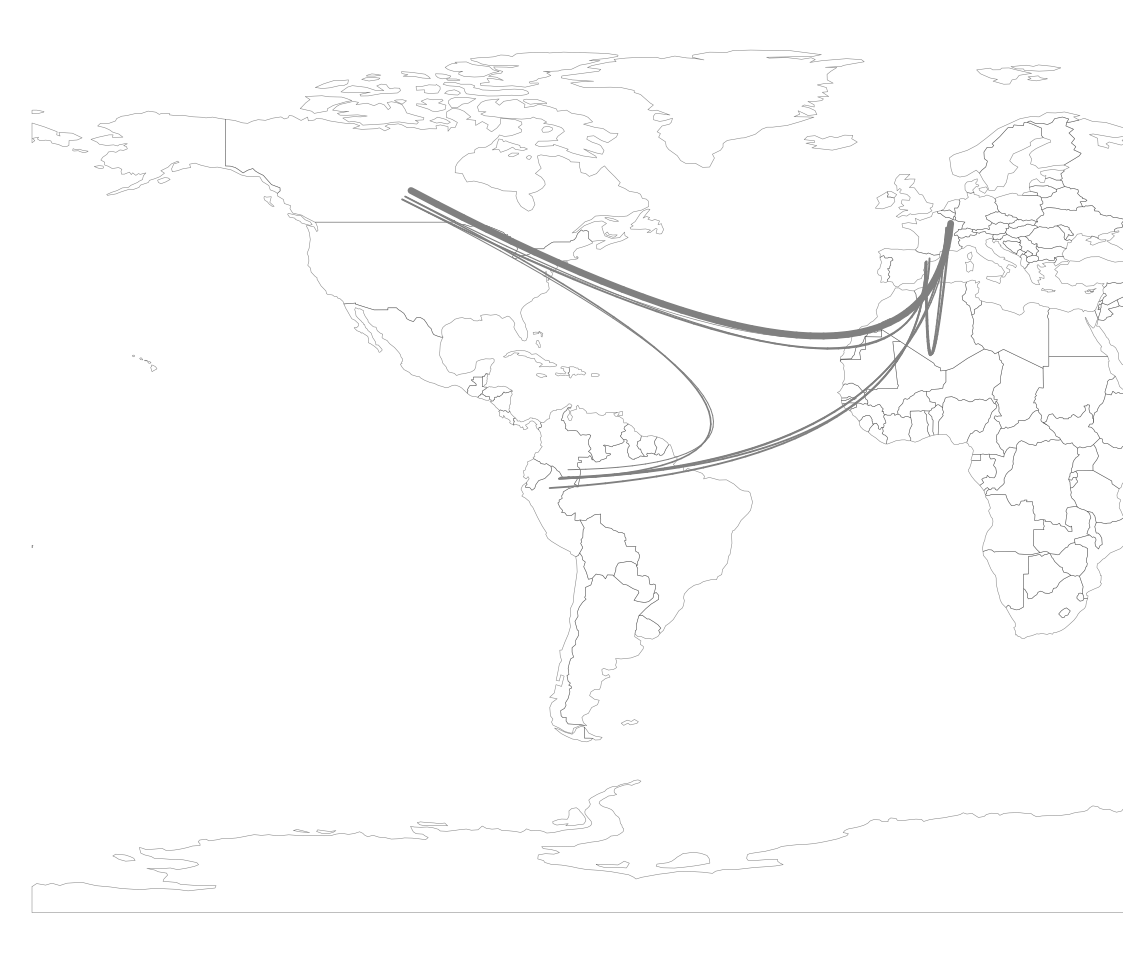

In [38]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(alpha=0.5, color="white", edgecolor="black", linewidth=0.5, figsize=(20,18))

# for country in division_order: 
#     world[world.name == country].plot(color=colors[country],
#                                       ax=ax, edgecolor="black",
#                                       linewidth=0.75)

root_path = "/Users/mparedes/Desktop/mpox_rhino/fixed_region_prev_sub_500_masked.log"
burnin=10000000
with open(root_path) as f:
    f = f.readlines()
for line in f:
    if not line.startswith("#"):
       
        l=line.strip('\n').split('\t')
        if l[0]=='state':
            header=l
            param_idx={x:i for i,x in enumerate(header)}
            params=header[1:]
            rootHeights={x:[] for x in params}
        elif float(l[0])>=burnin:
            for param in params:
                rootHeights[param].append(float(l[param_idx[param]]))


for headers in rootHeights.keys():
    if "region.rates" in headers:
        direction_mean = 0
        origin = headers.split(".")[2] 
        destination = headers.split(".")[3] 

        oriX,oriY=region_centroids[["lat", "long"]][region_centroids["region_coarse"] == origin].to_numpy()[0]
        desX,desY=region_centroids[["lat", "long"]][region_centroids["region_coarse"] == destination].to_numpy()[0]
        direction_mean = np.mean(rootHeights[headers])

        #destinationXs.append(desX)
        #destinationYs.append(desY)


        #print normalized_height,normalized_parent_height
        ## define Bezier curve
        distance=math.sqrt(math.pow(oriX-desX,2)+math.pow(oriY-desY,2))
        jitter=np.random.uniform(-2,2)


        ## get Bezier line coordinates
        curve=Bezier([(oriX,oriY),0.3,(desX+jitter,desY+jitter)],0.0,1.0,num=40)

        #midpoint=np.mean([normalized_parent_height,normalized_height])

        ## iterate through Bezier curve coordinates, alter colour according to height
        for i in range(len(curve)-1):
            x1,y1=curve[i]
            x2,y2=curve[i+1]
            frac=(i/float(len(curve)))

            ax.plot([x1,x2],[y1,y2],lw=2*direction_mean,color="gray",
                     solid_capstyle='round')
            #ax.plot([x1,x2],[y1,y2],lw=6+4*frac,color='k', solid_capstyle='round')
ax.set_axis_off()
ax.set_xlim(-185, 40)

#plt.savefig('map_wide.png')
plt.show() 